In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Датасет с данными по безработным синим воротничкам с 1982 по 1991 годы

In [5]:
df = pd.read_csv(r"https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Benefits.csv")
df.head()

,rownames,stateur,statemb,state,age,tenure,joblost,nwhite,school12,sex,bluecol,smsa,married,dkids,dykids,yrdispl,rr,head,ui
0,1,4.5,167,42,49,21,other,no,no,male,yes,yes,no,no,no,7,0.290631,yes,yes
1,2,10.5,251,55,26,2,slack_work,no,no,male,yes,yes,no,yes,yes,10,0.520202,yes,no
2,3,7.2,260,21,40,19,other,no,yes,female,yes,yes,yes,no,no,10,0.432490,yes,yes
3,4,5.8,245,56,51,17,slack_work,yes,no,female,yes,yes,yes,no,no,10,0.500000,no,yes
4,5,6.5,125,58,33,1,slack_work,no,yes,male,yes,yes,yes,yes,yes,4,0.390625,yes,no


### В датасете представлены данные как отражающие параметры работника (возраст, стаж, причина потери работы, уровень образования и т.д) так и общие параметры (индекс штата, уровень безработицы в штате, уровень выплаты по безработице).

### Целевая пееременная представлена в колонке "ui" и обозначает подавал ли уволенный сотрудник заявление на получение пособия и получил ли пособие по безработице

### Общий обзор датасета

In [7]:
df.shape

(4877, 19)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4877 entries, 0 to 4876
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  4877 non-null   int64  
 1   stateur   4877 non-null   float64
 2   statemb   4877 non-null   int64  
 3   state     4877 non-null   int64  
 4   age       4877 non-null   int64  
 5   tenure    4877 non-null   int64  
 6   joblost   4877 non-null   object 
 7   nwhite    4877 non-null   object 
 8   school12  4877 non-null   object 
 9   sex       4877 non-null   object 
 10  bluecol   4877 non-null   object 
 11  smsa      4877 non-null   object 
 12  married   4877 non-null   object 
 13  dkids     4877 non-null   object 
 14  dykids    4877 non-null   object 
 15  yrdispl   4877 non-null   int64  
 16  rr        4877 non-null   float64
 17  head      4877 non-null   object 
 18  ui        4877 non-null   object 
dtypes: float64(2), int64(6), object(11)
memory usage: 724.1+ KB


#### Проверка датасета на пропуски

In [14]:
df.isna().sum()

rownames    0
stateur     0
statemb     0
state       0
age         0
tenure      0
joblost     0
nwhite      0
school12    0
sex         0
bluecol     0
smsa        0
married     0
dkids       0
dykids      0
yrdispl     0
rr          0
head        0
ui          0
dtype: int64

###### Датасет не содержит пропуски

### Предварительный анализ данных¶

#### как распределяется количество уволенных по категориям

In [25]:
df['joblost'].unique()

array(['other', 'slack_work', 'position_abolished', 'seasonal_job_ended'],
      dtype=object)

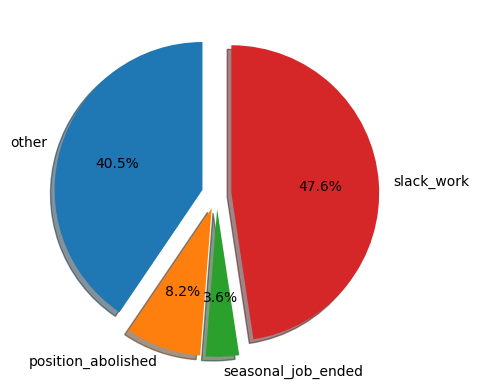

In [27]:
df_pie = df.groupby('joblost').agg({'joblost': 'count'})
df_pie.columns = ['s_count']
df_pie.reset_index
explode = (0.1, 0.1, 0.1, 0.1) 
fig, ax = plt.subplots()
ax.pie(df_pie['s_count'], labels = df_pie.index, explode=explode, autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.show()

### соотношение безработных "синих воротничков" получающих и не получающих пособие

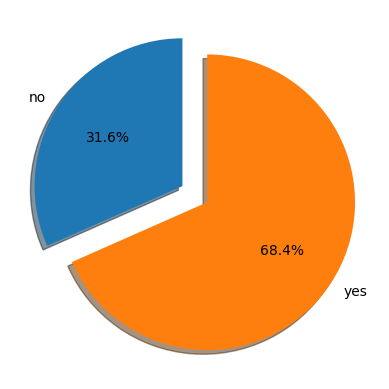

In [32]:
df_pie = df.groupby('ui').agg({'ui': 'count'})
df_pie.columns = ['s_count']
df_pie.reset_index
explode = (0.1, 0.1) 
fig, ax = plt.subplots()
ax.pie(df_pie['s_count'], labels = df_pie.index, explode = explode, autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.show()

### Поиск возможных взаимосвязей целевой переменной с данными датасета

### Одобрение выплат по безработице, трудовой стаж сотрудника, норма выплаты в регионе

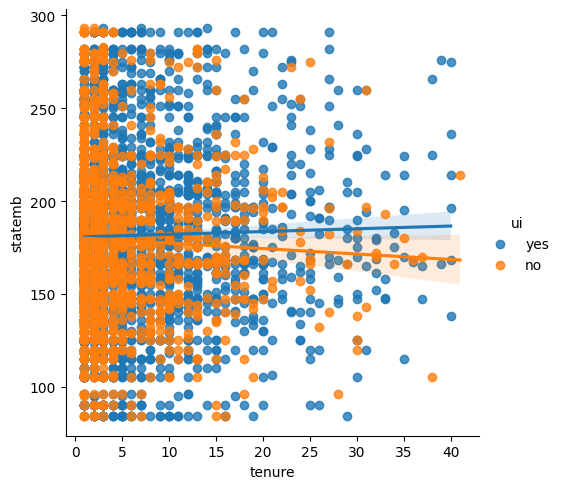

In [38]:
sns.lmplot(df, x='tenure', y = 'statemb', hue = 'ui')
plt.show()

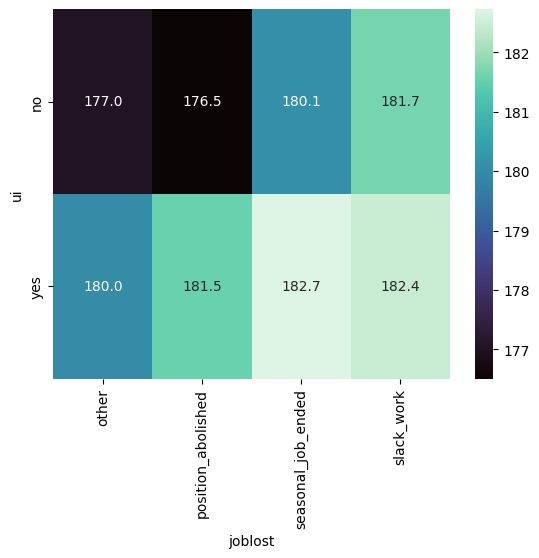

In [57]:
data_ed = df.groupby(['ui','joblost'])['statemb'].mean().unstack()
data_ed.head()
sns.heatmap(data_ed, annot = True, fmt='.1f', cmap="mako")
plt.show()

In [42]:
df_cr = pd.crosstab(df['ui'], df['joblost'])
stats.chi2_contingency(df_cr)

Chi2ContingencyResult(statistic=65.90763847789805, pvalue=3.207685000962116e-14, dof=3, expected_freq=array([[ 624.76768505,  127.10354726,   55.96350215,  734.16526553],
       [1351.23231495,  274.89645274,  121.03649785, 1587.83473447]]))

#### малое значение p-value указывает на то, что между переменными есть некоторая форма взаимосвязи

In [139]:
df_cr = pd.crosstab(df['ui'], df['nwhite'])
stats.chi2_contingency(df_cr1)

Chi2ContingencyResult(statistic=1.461546555305386, pvalue=0.22668420787516816, dof=1, expected_freq=array([[1248.90301415,  293.09698585],
       [2701.09698585,  633.90301415]]))

In [141]:
df_cr = pd.crosstab(df['ui'], df['sex'])
stats.chi2_contingency(df_cr1)

Chi2ContingencyResult(statistic=1.461546555305386, pvalue=0.22668420787516816, dof=1, expected_freq=array([[1248.90301415,  293.09698585],
       [2701.09698585,  633.90301415]]))

In [143]:
df_cr = pd.crosstab(df['ui'], df['school12'])
stats.chi2_contingency(df_cr1)

Chi2ContingencyResult(statistic=1.461546555305386, pvalue=0.22668420787516816, dof=1, expected_freq=array([[1248.90301415,  293.09698585],
       [2701.09698585,  633.90301415]]))

#### значение p-value указывает на то, что эти переменные с большой долей вероятноти не взаимосвязаны с целевой переменной

In [76]:
df['stateur'].corr(df['statemb'])

-0.24238552116605389

<Axes: xlabel='stateur', ylabel='statemb'>

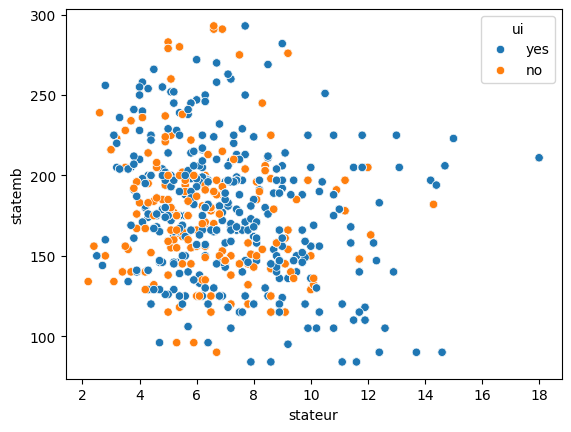

In [78]:
sns.scatterplot(data=df, x = 'stateur', y = 'statemb', hue = 'ui')

#### Переменные stateur и statemb имеют некоторую заметную корреляцию. Поэтому при обучении модели выберем один из параметров

## Выбор модели, которая с высокой точностью сможет предсказать вероятность получения пособия по безработице

### Создаю датасет со значимыми для анализа данными

In [85]:
df_n = df[['statemb', 'state', 'age', 'tenure', 'joblost', 'nwhite',	'school12',	'sex', 'married', 'dkids', 'dykids', 'head', 'ui']]
df_n.head()

,statemb,state,age,tenure,joblost,nwhite,school12,sex,married,dkids,dykids,head,ui
0,167,42,49,21,other,no,no,male,no,no,no,yes,yes
1,251,55,26,2,slack_work,no,no,male,no,yes,yes,yes,no
2,260,21,40,19,other,no,yes,female,yes,no,no,yes,yes
3,245,56,51,17,slack_work,yes,no,female,yes,no,no,no,yes
4,125,58,33,1,slack_work,no,yes,male,yes,yes,yes,yes,no


In [87]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4877 entries, 0 to 4876
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   statemb   4877 non-null   int64 
 1   state     4877 non-null   int64 
 2   age       4877 non-null   int64 
 3   tenure    4877 non-null   int64 
 4   joblost   4877 non-null   object
 5   nwhite    4877 non-null   object
 6   school12  4877 non-null   object
 7   sex       4877 non-null   object
 8   married   4877 non-null   object
 9   dkids     4877 non-null   object
 10  dykids    4877 non-null   object
 11  head      4877 non-null   object
 12  ui        4877 non-null   object
dtypes: int64(4), object(9)
memory usage: 495.4+ KB


### Для удобства обработки данных разделяю на числовые и категориальные, и категориальные переменные перевожу в числовой формат

In [92]:
cat_vars = ['joblost', 'nwhite',	'school12',	'sex', 'married', 'dkids', 'dykids', 'head']
num_vars = ['statemb', 'state', 'age', 'tenure']

In [94]:
X = df_n[['joblost', 'nwhite',	'school12',	'sex', 'married', 'dkids', 'dykids', 'head', 'statemb', 'state', 'age', 'tenure']].values
y = df_n['ui'].values

In [96]:
X = pd.get_dummies(df_n[cat_vars], drop_first = True, dtype = int)
X.head()

,joblost_position_abolished,joblost_seasonal_job_ended,joblost_slack_work,nwhite_yes,school12_yes,sex_male,married_yes,dkids_yes,dykids_yes,head_yes
0,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,1,0,1,1,1
2,0,0,0,0,1,0,1,0,0,1
3,0,0,1,1,0,0,1,0,0,0
4,0,0,1,0,1,1,1,1,1,1


In [98]:
y = pd.get_dummies(df_n['ui'], drop_first = True, dtype = int)

### Нормализация числовых переменных

In [101]:
scaler = MinMaxScaler()
scaler.fit(df_n[num_vars])
X[num_vars] = scaler.transform(df_n[num_vars])
X.head()

,joblost_position_abolished,joblost_seasonal_job_ended,joblost_slack_work,nwhite_yes,school12_yes,sex_male,married_yes,dkids_yes,dykids_yes,head_yes,statemb,state,age,tenure
0,0,0,0,0,0,1,0,0,0,1,0.397129,0.369048,0.707317,0.500
1,0,0,1,0,0,1,0,1,1,1,0.799043,0.523810,0.146341,0.025
2,0,0,0,0,1,0,1,0,0,1,0.842105,0.119048,0.487805,0.450
3,0,0,1,1,0,0,1,0,0,0,0.770335,0.535714,0.756098,0.400
4,0,0,1,0,1,1,1,1,1,1,0.196172,0.559524,0.317073,0.000


### Разделение на обучающую, тестовую и прогнозную части 

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 20)

In [108]:
X_test, X_forecast, y_test, y_forecast = train_test_split(X_test, y_test, test_size = 0.5, random_state = 20)

### Проверяю несколько моделей для оценки какая из них более эффективно прогнозирует результат решения по выплате пособия по безработице

### Модель KNeighbors

In [111]:
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(
    'Precision:', np.round(precision_score(y_test, y_pred),3), 
    'Recall', np.round(recall_score(y_test, y_pred),3)
)

Precision: 0.691 Recall 0.771


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


#### поиск значения гиперпараметра, при котором значения модели будут более высокими

In [114]:
for i in range(3, 15, 2):
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print('Neigbors:', i, 
          'Precision:', np.round(precision_score(y_test, y_pred),3), 
          'Recall', np.round(recall_score(y_test, y_pred),3)
         )

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Neigbors: 3 Precision: 0.691 Recall 0.771
Neigbors: 5 Precision: 0.701 Recall 0.842


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Neigbors: 7 Precision: 0.703 Recall 0.87
Neigbors: 9 Precision: 0.704 Recall 0.882
Neigbors: 11 Precision: 0.703 Recall 0.888
Neigbors: 13 Precision: 0.695 Recall 0.889


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


#### Модель KNeighbors показала лучший результат Precision: 0.703 и Recall: 0.888 при использовании гиперпараметра Neigbors = 11

### Модель DecisionTree

In [123]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print(
    'Precision:', np.round(precision_score(y_test, y_pred),3), 
    'Recall', np.round(recall_score(y_test, y_pred),3)
)

Precision: 0.705 Recall 0.686


#### Модель DecisionTree показала результат Precision: 0.705 Recall 0.686

### Модель RandomForest

In [130]:
rf_clf = RandomForestClassifier(max_depth=20, random_state=20)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(
    'Precision:', np.round(precision_score(y_test, y_pred),3), 
    'Recall', np.round(recall_score(y_test, y_pred),3)
)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Precision: 0.708 Recall 0.905


#### поиск значения гиперпараметра, при котором значения модели будут более высокими

In [135]:
for i in range(1, 20, 2):
    rf_clf = RandomForestClassifier(max_depth=i, random_state=20)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    print('Depth:', i, 
          'Precision:', np.round(precision_score(y_test, y_pred),3), 
          'Recall', np.round(recall_score(y_test, y_pred),3)
         )

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Depth: 1 Precision: 0.693 Recall 1.0
Depth: 3 Precision: 0.693 Recall 1.0


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Depth: 5 Precision: 0.696 Recall 1.0
Depth: 7 Precision: 0.704 Recall 0.981


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Depth: 9 Precision: 0.704 Recall 0.975


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Depth: 11 Precision: 0.706 Recall 0.945


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Depth: 13 Precision: 0.712 Recall 0.929


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Depth: 15 Precision: 0.708 Recall 0.92


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Depth: 17 Precision: 0.713 Recall 0.901


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Depth: 19 Precision: 0.71 Recall 0.899


#### Модель RandomForest по моему мнению показала лучший результат сочетания точности и полноты предсказания Precision: 0.712 Recall 0.929 при использовании гиперпараметра depth = 13

## Из трех моделей предсказания наилучший результат был получен при использовании модели предсказания RandomForest